## Tutorial 0 - Document Classification

In this tutorial, we'll introduce feed forward network, word embedding concept and apply it to binary document classification task.

### Introduction

#### Feed Forward Network
A feed forward network contains multiple neurons arranged in layers. 
Following image shows a simple feed forward network consisting 3 layer. The first layer is called input layer. The last layer is called output layer. Layers between input layer and output layer are hidden layers. Output of previous layer is input of the next layer. We can have one or multiple hidden layers in a network.

![ffn](figures/ffn.png "Title")



#### Artificial Neuron
Artificial neuron is the basic computation unit of a neural network.

![neuron](figures/neuron.jpg "Title")

Given an input vector $\pmb{x}$, neuron output ${y}$ is computed by applying non-linear function on the weighted sum of input.

$$\pmb{z} = \pmb{w}\pmb{x} + \pmb{b} \\
   {y} = f(\pmb{z})$$
   
The non-linear function f is also called __activation function__. Common choices of activation function are:

* __sigmoid__: map real-value to output in range [0,1]
$$\sigma(z) = \frac{1}{1+\exp(-z)}$$

* __tanh__: map real-value to output in range [-1,1]
$$\tanh(z) = \frac{\exp(z) - \exp(-z)}{\exp(z)+\exp(-z)}$$

* __ReLU__: map real-value to output in range [0,$\infty$]
$$\textrm{ReLU}(x) = \max(0,x)$$

* __softmax__: map real-value to output in range [0,1] and normalize each output such that the total sum of outputs is equal to 1.
$$\textrm{softmax}(z)_i = \frac{\exp(z_i)}{\sum_{k} \exp(z_k)}$$

### Document Classification
In this tutorial, we consider the customer review classification task. Given a customer review, we want to identify if it is a negative review (Class 0) or positive review (Class 1). This is a binary document classification task. We aim to train a model to learn the probability of document $d$ being of class $c$: $p(c|d)$. To achieve this goal, we have to decide:
* How to represent text document $d$?
* How to model the probability $p(c|d)$

#### Data preparation
Dataset of this tutorial can be found in `data/tut0/sentiment-labelled-sentences` folder. We'll use Amazon customer review dataset. Amazon customer review dataset contains 1000 review (500 negative and 500 positive). We will split this dataset into training set (800 reviews), dev set (100 reviews) and test set (100 reviews). Each set will have the same negative:postive ratio.

In [1]:
import numpy as np
import nltk
import collections
# nltk.download('punkt') #Download punkt if you haven't

After loading, we preprocess each document by lowercasing and tokenizing it into words. In this tutorial, we use nktl word tokenizer.

In [2]:
# tokens = nltk.word_tokenize(sentence)
pos_data = []
neg_data = []
with open('./data/tut0/sentiment-labelled-sentences/amazon_cells_labelled.txt') as f:
    for line in f:
        s = line.strip().split('\t')
        s[0] = nltk.word_tokenize(s[0].lower())
        if int(s[1]) == 0:
            neg_data.append(s[0])
        else:
            pos_data.append(s[0])

Construct vocabulary

In [3]:
counter = collections.Counter([x for sublist in neg_data for x in sublist])
counter.update([x for sublist in pos_data for x in sublist])
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
vocab_size = len(count_pairs)
words, _ = list(zip(*count_pairs))

#### Word embedding
In natural language processing, a text corpus is tokenized into sequence of tokens which are usually words. Tokens are encoded into vectors so that they can be used by statistical classifiers. The simplest approach in vectorizing a word is one-hot encoding, that is, each word in vocabulary corresponds to a unique feature in the vector. Considering a vocabulary of $V$ words, a document of $N$ words will be represented by a very sparse matrix of dimension $N \times V$ in which there are only $N$ non-zero values. 

One-hot encoding suffers from very sparse and very high dimension issues, even with a small vocabulary containing only a few thousands words. An alternate approach is word embedding which uses lower dimension and dense vector representation. The embeddings are the word representation in which the representaiton dimension is much smaller than the vocabulary size $V$. A word embedding is often "pre-trained" based on a big corpus, ideally with a domain related to the NLP task of interest. The embeddings of vocabulary words can be also treated as  neural network parameters and learned simultaneously with other network parameters.

#### Pretrained word embedding
In this tutorial, we'll use pretrained [GloVe word embedding](https://nlp.stanford.edu/projects/glove/) for our model.The glove embedding contains word embedding for most common 400K words. Each word is represented by a 50-dimension vector. We only load a subset of those belong to our constructed vocabulary.

In [4]:
emb_lookup = {}
with open('./data/embedding/glove.6B.50d.txt') as f:
    for line in f:
        s = line.strip().split()
        if s[0] in words:
            emb_lookup[s[0]] = [float(i) for i in s[1:]]
            
words = emb_lookup.keys()
word_to_id = dict(zip(words, range(len(words))))

One advantage of word embedding is that it can capture word similarity. Here we only plot 100 words from our vocabulary. From t-SNE plot, we can see that words with similar meanings are very close to each other.

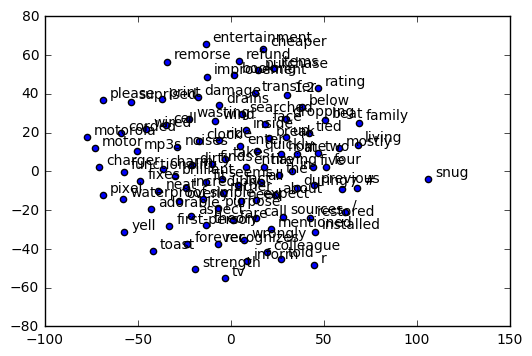

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
wv = [emb_lookup[k] for k in list(words)[:100]]
Y = tsne.fit_transform(wv)
 
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

#### Document representation
One simple approach to represent document is to represent it as an average of their word embedding. These document vectors will be input to our classification model

In [6]:
# Lookup embedding
neg_data = [[emb_lookup[w] for w in ex if w in words] for ex in neg_data]
pos_data = [[emb_lookup[w] for w in ex if w in words]for ex in pos_data]

# Calculate document vector.
neg_data = [[np.mean(np.asarray(ex), axis=0),0] for ex in neg_data]
pos_data = [[np.mean(np.asarray(ex), axis=0), 1] for ex in neg_data]

#### Train, dev and test set
We will split this dataset into training set (800 reviews), dev set (100 reviews) and test set (reviews). Each set will have the same negative:postive ratio.

While training set is used to train model, dev set is used for model selection. Test set is used to evaluate model performance on the task.

In [7]:
from random import shuffle
shuffle(neg_data)
shuffle(pos_data)
train = neg_data[:400] + pos_data[:400]
shuffle(train)
dev = neg_data[400:450] + pos_data[400:450]
shuffle(dev)
test = neg_data[450:] + pos_data[450:]
shuffle(test)

####  Probability $p(c|d)$ estimation
We'll use a 3 layer feed forward network to estimate probability $p(c|d)$.
* Input layer: bypass the document vector $d$
* Hidden layer: $h=\tanh(W_hd+b_h)$
* Ouput layer: output layer consists of 2 unit, corresponding to our 2 predefined class: positive and negative
$$p(c|d)=\textrm{softmax}(W_\textrm{softmax}h+b_\textrm{softmax})$$

Our network parameters are $\theta = \{W_h, b_h, W_\textrm{softmax}, b_\textrm{softmax}\}$

#### Train model
Our neural network language model can be trained based on the maximum likelihood principle. Suppose we are given a data set  containing valid sentences of the language. Then the likelihood of the data based _D_ on our model is: 

$$P(D) = \displaystyle \prod_{s \in D}P(s) = \displaystyle \prod_s \prod_{i=1}^{|s|}P_{\theta}(s_i|s_{i-1})$$

where $\theta$ is model parameters.

Closed form solution doesn’t exist. We use gradient-based optimization method to search for minimum of negative loglikehood of eqn (4) $- \log P(D)$. The gradient always points in the direction of steepest increase in the loss function (negative log likelihood). The gradient descent algorithm takes a step in the direction of the negative gradient in order to reduce loss as quickly as possible. Model parameters are iteratively updated as:
$$\theta = \theta - \eta \frac{\partial\log P(D)}{\partial \theta} $$
where $\eta$ is learning rate hyperparameter specifying how much to update the parameters. If learning rate is too small, it will take too long to train model. In contrast, if learning rate is too large, the optimization process may not converge.

Following image illustrate neural network training process. In forward pass, we compute the output and loss against the ground-truth. In backward pass, we back propagate derivative of loss against each parameters and update parameters.
![training.png](attachment:training.png)

#### Minibatch
(Batch) Gradient Descent (BGD) algorithm updates model parameters by evaluating gradient over the full training set. In the other extreme, Stochastic Gradient Descent (SGD) algorithm updates parameters after every single example. Full batch gradient descent works well for small dataset. For very large dataset containing millions of example, BGD take very long time to complete a single iteration. SGD updates model parameters more frequent but is very noisy. 

Mini-batch SGD is a compromise between BGD and SGD by update model parameters based on a subset of training dataset aka a mini-batch. A mini-batch size is often chosen between 32-1000 examples. Mini-batch SGD reduces noise in SGD and more efficient than BGD.

### Tensorflow Implementation

In [8]:
import tensorflow as tf

#### Neural Network Declaration
Our hidden layers will contains 100 hidden unit. embedding_size is the size of document vector.

In Tensorflow, we declare network input using `tf.placeholder`. 
Our network contains 2 input:
* A minibatch of document vectors $x$: $x$ has dimension (batch_size x embedding_size). Batch_size will be determined at run time.
* A minibatch of true class $y$: $y$ has dimension (batch_size) and is used to calculate loss

In [9]:
hidden_size = 100
embedding_size = 50
x = tf.placeholder(tf.float32, shape=(None, embedding_size), name="x")
y = tf.placeholder(tf.int32, shape=(None), name="y")

We declare model parameters with `tf.Variable`.

In [10]:
# declare model parameter
W_h = tf.Variable(np.random.rand(embedding_size, hidden_size), name="W_h", dtype=tf.float32)
b_h = tf.Variable(np.zeros(hidden_size), name="b_h", dtype=tf.float32)
W_softmax = tf.Variable(np.random.rand(hidden_size, 2), name="W_softmax", dtype=tf.float32)
b_softmax = tf.Variable(np.zeros(2), name="b_softmax", dtype=tf.float32)

Next, we'll declare the network layers.

In [11]:
# hidden layer
hidden = tf.tanh(tf.nn.xw_plus_b(x, W_h, b_h))

# output layer
output = tf.nn.xw_plus_b(hidden, W_softmax, b_softmax)

Then, we calculate cross entropy loss.

In [12]:
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=output, labels=y)
loss_op = tf.reduce_mean(crossent)

We train our model using SGD. Here we declare the optimizer and start backward pass by calling `minimize`

In [13]:
# optimize with SGD, learning rate = 0.01
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss_op)


Predicted class is the class with highest predicted probability

In [14]:
pred_op = tf.argmax(tf.nn.softmax(output), 1)

#### Train model
So far, we only declare the static graph of our neural network. Our network won't train or execute until we run it in a session.

Now, we gonna create and initialize a TensorFlow session. 

In [15]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Finally, we start training model. The following code declares our training loop. We gonna train our model in 20 epoches with minibatch size 20. We perform validation every 10 step to check model performance so far.

To execute the network, we need to specify our desired output and pass input to network (feed_dict) using `sess.run` method. Noted that not all nodes in the network are executed. The network will stop when desired output is reached.

For example, in training step, our desired output is loss operation (loss_op) and training operation (train_op - output of `optimizer.minimize(loss)`). Therefore, both forward and backward pass are executed.

In validation step, our desired output is loss operation and the prediction output. Then, only forward pass is executed.

In [16]:
num_epoch = 20
batch_size = 20
num_step = int(len(train) / batch_size)
history_loss = []
history_dev_loss = []
history_dev_acc = []
dev_x = np.asarray(dev)[:,0].tolist()
dev_y = np.asarray(dev)[:,1].tolist()

for epoch in range(num_epoch):
    #Shuffle training data every epoch
    np.random.shuffle(train)
    for step in range(num_step):
        # take a minibatch of training data
        minibatch = train[step*batch_size:(step+1)*batch_size]
        batch_x = np.asarray(minibatch)[:,0].tolist()
        batch_y = np.asarray(minibatch)[:,1].tolist()  
        
        #Training
        loss, _ = sess.run([loss_op, train_op], 
                           feed_dict={x: batch_x, y: batch_y})
        if (step + 1) % 10 == 0:                
            #run on validation set after every 10 step
            #validation step
            dev_loss, pred = sess.run([loss_op, pred_op], feed_dict={x: dev_x, y: dev_y}) 
            accuracy = (pred == dev_y).sum()/pred.size
            history_loss.append(loss)
            history_dev_loss.append(dev_loss)
            history_dev_acc.append(accuracy)
            print("Epoch " + str(epoch) + " Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Dev loss {:.4f}".format(dev_loss) + ", Dev accuracy {:.4f}".format(accuracy))

Epoch 0 Step 9, Minibatch Loss= 0.8957, Dev loss 0.7402, Dev accuracy 0.4900
Epoch 0 Step 19, Minibatch Loss= 0.5984, Dev loss 0.7066, Dev accuracy 0.5500
Epoch 0 Step 29, Minibatch Loss= 0.6698, Dev loss 0.6754, Dev accuracy 0.5700
Epoch 0 Step 39, Minibatch Loss= 0.6143, Dev loss 0.6466, Dev accuracy 0.6200
Epoch 1 Step 9, Minibatch Loss= 0.4841, Dev loss 0.6268, Dev accuracy 0.6800
Epoch 1 Step 19, Minibatch Loss= 0.6598, Dev loss 0.6213, Dev accuracy 0.6800
Epoch 1 Step 29, Minibatch Loss= 0.4979, Dev loss 0.5882, Dev accuracy 0.7000
Epoch 1 Step 39, Minibatch Loss= 0.4654, Dev loss 0.5674, Dev accuracy 0.7400
Epoch 2 Step 9, Minibatch Loss= 0.5171, Dev loss 0.5544, Dev accuracy 0.7600
Epoch 2 Step 19, Minibatch Loss= 0.5064, Dev loss 0.5380, Dev accuracy 0.7600
Epoch 2 Step 29, Minibatch Loss= 0.5788, Dev loss 0.5275, Dev accuracy 0.8100
Epoch 2 Step 39, Minibatch Loss= 0.4736, Dev loss 0.5139, Dev accuracy 0.8000
Epoch 3 Step 9, Minibatch Loss= 0.5700, Dev loss 0.5025, Dev accura

The following figure plots model training loss (red curve), dev loss (blue curve) and dev accuracy (green curve) over time.

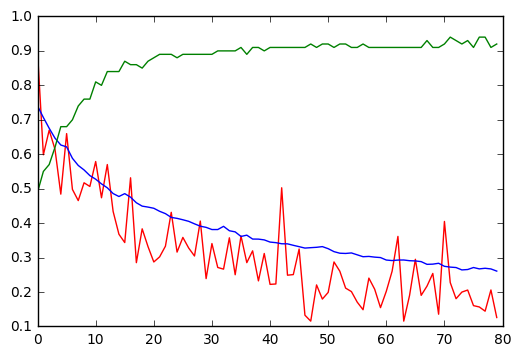

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history_loss, 'r')
plt.plot(history_dev_loss, 'b')
plt.plot(history_dev_acc, 'g')

#### Inference
Now, let's evaluate our model accuracy on test data. Noted that ground truth is not available at inference time.

In [18]:
np.random.shuffle(test)
test_x = np.asarray(test)[:,0].tolist()
test_y = np.asarray(test)[:,1].tolist()

#inference step
pred = sess.run(pred_op, feed_dict={x: test_x}) 
accuracy = (pred == test_y).sum()/pred.size
print("Test accuracy {:.4f}".format(accuracy))

Test accuracy 0.9900
